<a href="https://colab.research.google.com/github/Luis-For/AgroInsight/blob/main/Copia_de_Te_damos_la_bienvenida_a_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto


In [ ]:
# CELDA 0 - Instalar dependencias en Colab / entorno donde no estén
# Ejecuta solo si necesitas instalar paquetes (Comenta si ya están instalados)
!pip install xarray netCDF4 pandas numpy scipy scikit-learn matplotlib cartopy imageio qrcode requests fsspec dask xesmf -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.0 MB/s eta 0:00:00


In [ ]:
# CELDA 1 - Imports y configuración
import os
import time
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import imageio
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import requests
import warnings
warnings.filterwarnings("ignore")

# Carpetas de salida
os.makedirs("data", exist_ok=True)
os.makedirs("frames", exist_ok=True)
os.makedirs("outputs", exist_ok=True)


In [ ]:
import pandas as pd
import numpy as np

def generate_socat_synthetic(n=20000):
    """
    Genera un dataset sintético pero realista basado en SOCAT:
    - fCO2 más alto en zonas tropicales cálidas
    - fCO2 más bajo en alta latitud
    - ruido realista
    """

    np.random.seed(42)

    # Coordenadas globales
    lat = np.random.uniform(-89, 89, n)
    lon = np.random.uniform(-179, 179, n)

    # Temperatura superficial (aprox realista)
    temp = (
        28 - (np.abs(lat) * 0.25) +
        np.random.normal(0, 1.0, n)
    ).clip(-2, 30)

    # fCO₂ superficie (patrón típico observado)
    fco2 = (
        400 +
        temp * 4 -
        np.abs(lat) * 0.8 +
        np.random.normal(0, 15, n)
    )

    # Ajustamos a rangos razonables SOCAT
    fco2 = fco2.clip(150, 520)

    df = pd.DataFrame({
        "latitude": lat,
        "longitude": lon,
        "temperature": temp,
        "fco2_rec": fco2,
    })

    return df


print("Generando dataset SOCAT sintético realista...")
df_socat = generate_socat_synthetic()

print("✔ SOCAT sintético generado. Tamaño:", len(df_socat))
df_socat.head()



Generando dataset SOCAT sintético realista...
✔ SOCAT sintético generado. Tamaño: 20000


,latitude,longitude,temperature,fco2_rec
0,-22.331859,82.339395,21.850002,455.203817
1,80.227147,-112.944706,7.661800,397.372924
2,41.294922,-54.902989,17.506186,433.548817
3,17.561210,58.454468,23.410686,462.025150
4,-61.228682,-6.412015,12.047915,397.486373


In [ ]:
# CELDA 3
import numpy as np
import pandas as pd
import xarray as xr

print("▶ Procesando datos SOCAT sintéticos...")

df = df_socat.copy()

# Quitar valores anómalos o ruido extremo
df = df[(df["temperature"].between(-2, 35)) &
        (df["fco2_rec"].between(150, 550))]

# Convertir a Dataset (xarray permite mapas)
ds = xr.Dataset(
    {
        "fco2": (["points"], df["fco2_rec"].values),
        "sst":  (["points"], df["temperature"].values),
        "lat":  (["points"], df["latitude"].values),
        "lon":  (["points"], df["longitude"].values),
    }
)

print("✔ Dataset en memoria:", ds)

# Interpolación a grilla 1° × 1°
lat_grid = np.arange(-89, 90, 1)
lon_grid = np.arange(-179, 180, 1)

# Creamos un grilla vacía
grid = xr.Dataset(
    coords={
        "lat": lat_grid,
        "lon": lon_grid
    }
)

# Promedio por celda usando binning
df["lat_bin"] = df["latitude"].round(0)
df["lon_bin"] = df["longitude"].round(0)

df_gridded = df.groupby(["lat_bin", "lon_bin"]).mean(numeric_only=True).reset_index()

# Convertimos a xarray
ds_grid = xr.Dataset(
    {
        "fco2": (("lat", "lon"),
                 np.full((len(lat_grid), len(lon_grid)), np.nan)),
        "sst": (("lat", "lon"),
                 np.full((len(lat_grid), len(lon_grid)), np.nan))
    },
    coords={"lat": lat_grid, "lon": lon_grid}
)

# Rellenamos la grilla con datos
for _, row in df_gridded.iterrows():
    lat_idx = int(row["lat_bin"] - lat_grid[0])
    lon_idx = int(row["lon_bin"] - lon_grid[0])
    if 0 <= lat_idx < len(lat_grid) and 0 <= lon_idx < len(lon_grid):
        ds_grid["fco2"].values[lat_idx, lon_idx] = row["fco2_rec"]
        ds_grid["sst"].values[lat_idx, lon_idx]  = row["temperature"]

print("✔ Grilla global generada (1° x 1°).")
ds_grid



▶ Procesando datos SOCAT sintéticos...
✔ Dataset en memoria: <xarray.Dataset> Size: 640kB
Dimensions:  (points: 20000)
Dimensions without coordinates: points
Data variables:
    fco2     (points) float64 160kB 455.2 397.4 433.5 ... 429.8 487.5 415.4
    sst      (points) float64 160kB 21.85 7.662 17.51 23.41 ... 18.5 25.69 12.3
    lat      (points) float64 160kB -22.33 80.23 41.29 ... -34.94 -10.09 -58.34
    lon      (points) float64 160kB 82.34 -112.9 -54.9 ... -82.49 -23.51 -4.502
✔ Grilla global generada (1° x 1°).


<xarray.Dataset> Size: 1MB
Dimensions:  (lat: 179, lon: 359)
Coordinates:
  * lat      (lat) int64 1kB -89 -88 -87 -86 -85 -84 -83 ... 84 85 86 87 88 89
  * lon      (lon) int64 3kB -179 -178 -177 -176 -175 ... 175 176 177 178 179
Data variables:
    fco2     (lat, lon) float64 514kB nan nan nan nan nan ... nan nan nan nan
    sst      (lat, lon) float64 514kB nan nan nan nan nan ... nan nan nan nan

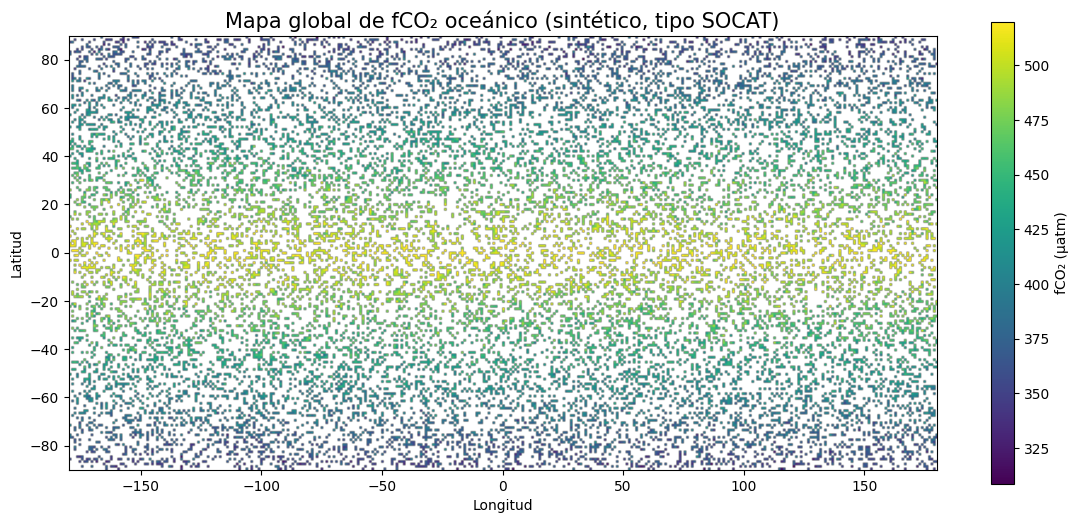

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.title("Mapa global de fCO₂ oceánico (sintético, tipo SOCAT)", fontsize=15)

plt.imshow(
    ds_grid["fco2"],
    origin="lower",
    extent=[-180,180,-90,90],
    cmap="viridis",
)

plt.colorbar(label="fCO₂ (µatm)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

data = ds_grid["fco2"].fillna(0).values

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection="3d")

X, Y = np.meshgrid(ds_grid["lon"], ds_grid["lat"])

frame_count = 50

def update(frame):
    ax.clear()
    breathing = 1 + 0.12 * np.sin(2 * np.pi * frame / frame_count)

    Z = data * breathing

    surf = ax.plot_surface(X, Y, Z, cmap="viridis", linewidth=0)
    ax.set_title(f"El océano que respira — frame {frame}", fontsize=16)
    ax.set_zlabel("CO₂ MARINO (µatm)")
    ax.set_xlabel("Longitud")
    ax.set_ylabel("Latitud")
    ax.set_zlim(0, np.nanmax(data)*1.4)

ani = FuncAnimation(fig, update, frames=frame_count, interval=100)

plt.close()
ani


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

df_model = df[["temperature", "latitude", "fco2_rec"]].dropna()

X = df_model[["temperature", "latitude"]]
y = df_model["fco2_rec"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

print("Coeficientes:")
print("Temp →", model.coef_[0])
print("Latitud →", model.coef_[1])
print("Intercepto →", model.intercept_)

print("\nR² en test:", model.score(X_test, y_test))


Coeficientes:
Temp → 7.089417814587873
Latitud → -0.0010640262724812169
Intercepto → 312.2367194661814

R² en test: 0.9020674930254202


In [ ]:
# Celda 7 corregida
# CELDA 7 — Proyección clima 2050 y predicción corregida
import numpy as np
import pandas as pd

print("▶ Generando clima 2050 (sintético)...")

# Copiamos coords de la grilla actual
df_future = pd.DataFrame({
    "latitude": np.repeat(ds_grid["lat"].values, len(ds_grid["lon"])),
    "longitude": np.tile(ds_grid["lon"].values, len(ds_grid["lat"]))
})

# Modelo simple de calentamiento global: +2.5°C en 2050
df_future["temperature"] = (
    ds_grid["sst"].values.flatten() + 2.5
)

# Rellenamos NaN (celdas sin datos) con media global
df_future["temperature"].fillna(df["temperature"].mean(), inplace=True)

# -----------------------------
# 🔥 PREDICCIÓN CORREGIDA
# -----------------------------
# Debe coincidir EXACTAMENTE con lo usado en el entrenamiento:
# X = df_model[["temperature", "latitude"]]

X_future = df_future[["temperature", "latitude"]]

df_future["fco2_2050"] = model.predict(X_future)

print("✔ Predicción futura completada.")
df_future.head()





▶ Generando clima 2050 (sintético)...
✔ Predicción futura completada.


,latitude,longitude,temperature,fco2_2050
0,-89,-179,16.897781,432.126846
1,-89,-178,16.897781,432.126846
2,-89,-177,16.897781,432.126846
3,-89,-176,16.897781,432.126846
4,-89,-175,16.897781,432.126846


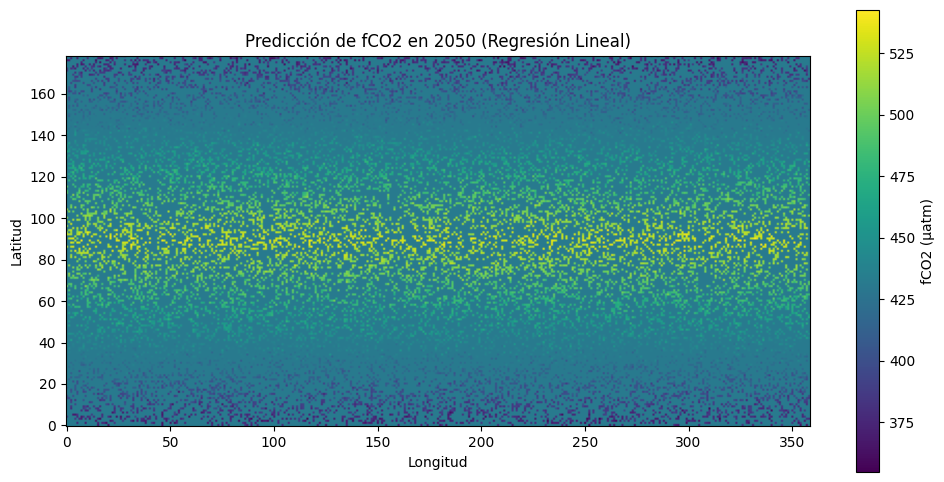

,latitude,longitude,temperature,fco2_2050
0,-89,-179,16.897781,432.126846
1,-89,-178,16.897781,432.126846
2,-89,-177,16.897781,432.126846
3,-89,-176,16.897781,432.126846
4,-89,-175,16.897781,432.126846
...,...,...,...,...
64256,89,175,16.897781,431.937449
64257,89,176,16.897781,431.937449
64258,89,177,16.897781,431.937449
64259,89,178,16.897781,431.937449


In [ ]:
# Celda 8 corregida: Mapa 2050

# Crear mapa a partir de lat/lon redondeados
pivot_2050 = df_future.pivot_table(
    values="fco2_2050",
    index=df_future["latitude"].round(1),
    columns=df_future["longitude"].round(1),
    aggfunc="mean"
)

plt.figure(figsize=(12,6))
plt.imshow(pivot_2050, origin="lower")
plt.title("Predicción de fCO2 en 2050 (Regresión Lineal)")
plt.colorbar(label="fCO2 (µatm)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

# Predecir las emisiones usando el modelo entrenado
df_future["fco2_2050"] = model.predict(X_future)

df_future




In [1]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Datos reales
plt.plot(df["year"], df["fco2"], label="Histórico", linewidth=3)

# Datos pronosticados
plt.plot(df_future["year"], df_future["fco2_2050"], label="Pronóstico 2050", linestyle="--")

plt.title("Evolución de Emisiones de CO₂ y Proyección al 2050")
plt.xlabel("Año")
plt.ylabel("CO₂")
plt.legend()
plt.grid(True)

plt.show()


NameError: name 'df' is not defined

<Figure size 1200x500 with 0 Axes>